In [1]:
# import necessary modules
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# set variable for file_path and data_dir
file_path = r"/Users/hemu/Desktop/Updated_work_on_Deep_Learning/Research_work_on_Deep_Learning/Pneumonia/chest_xray/Alzheimers_Image_data/dataset"
data_dir = pathlib.Path(file_path)

In [3]:
# Split train and validation data
SEED = 1234
BATCH_SIZE = 10
IMG_SIZE = (160,160)

train_data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                         validation_split = 0.2,
                                                         subset = 'training',
                                                         seed = SEED,
                                                         image_size = IMG_SIZE,
                                                         batch_size = BATCH_SIZE,
                                                         shuffle = True
                                                         )

val_data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       seed = SEED,
                                                       image_size = IMG_SIZE,
                                                       batch_size = BATCH_SIZE,
                                                       shuffle = True
                                                       )

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [4]:
print(f"total train data per batch: {len(train_data)}")
print(f"total validation data per batch: {len(val_data)}")

total train data per batch: 512
total validation data per batch: 128


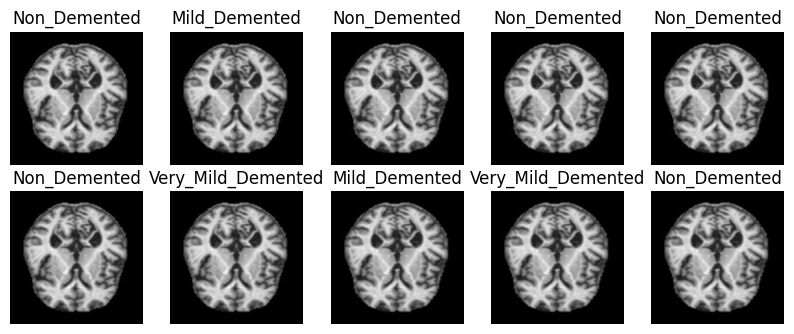

In [5]:
# set variable for class_names
class_names = train_data.class_names

# plot the train_data image
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
  for i in range(10):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[1].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [6]:
# perform split of validation data into test data
val_batches = tf.data.experimental.cardinality(val_data)
test_data = val_data.take(val_batches//2)
val_data = val_data.skip(val_batches//2)

In [7]:
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_data)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_data)}")

Number of validation batches: 64
Number of test batches: 64


In [8]:
print(f"total train data: {len(train_data)}")
print(f"total validation data: {len(val_data)}")
print(f"total test data: {len(test_data)}")

total train data: 512
total validation data: 64
total test data: 64


In [9]:
# create prefetch dataset for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size = AUTOTUNE)
val_data = val_data.prefetch(buffer_size = AUTOTUNE)
test_data = test_data.prefetch(buffer_size = AUTOTUNE)

In [10]:
# preprocess image input to rescale the image to fit into the pre-trained model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet'
                                         )

In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [13]:
# Freeze the entire base_model
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [14]:
# set variable for classfier layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# set variable for output layer
nClass = len(class_names)
prediction_layer = tf.keras.layers.Dense(nClass, activation = 'softmax')

In [15]:
# re-construct the model
inputs = tf.keras.Input(shape = (160,160,3))
x = preprocess_input(inputs)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy']
              )

In [17]:
# check the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 160, 160, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 160, 160, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [18]:
#tf.keras.utils.plot_model(model)

In [19]:
loss0, accuracy0 = model.evaluate(val_data)

print("---------------------------------------------Before Training---------------------------------------------")
print("loss", loss0)
print("accuracy", accuracy0)

64/64 [==============================] - 30s 469ms/step - loss: 6.3224 - accuracy: 0.3266
---------------------------------------------Before Training---------------------------------------------
loss 6.322396755218506
accuracy 0.3265624940395355


In [20]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from gc import callbacks
import datetime, os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
es_callback = callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 2)

In [21]:
# start train the model
initial_epochs = 1
history = model.fit(train_data,
                    epochs = initial_epochs,
                    validation_data = val_data,
                    callbacks = [tensorboard_callback, es_callback])

512/512 [==============================] - 346s 675ms/step - loss: 3.2929 - accuracy: 0.3863 - val_loss: 1.6190 - val_accuracy: 0.5109


In [22]:
# Perform FINE TUNING of the trained model
# In the first feature extraction training, the model was only trained a few layers on top of VGG19 base_model. The weights of the pretrained network were not updated during training
# Fine_tuning is method to increase performance even further or "fine-tunes" the weights of the top layer of the VGG19 model alongside the classifier added
# We need to unfreeze the top layers- pf the base model
base_model.trainable = True

In [23]:
# let's take a look at the model layers
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [24]:
# So, we are going to fine-tune 10 layers ahead
fine_tune_at = 10

# Freeze all the layer before "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


In [25]:
# compile the model again
# As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = ['accuracy'])


In [26]:
# lets check the model again
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 160, 160, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 160, 160, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [27]:
# Now, we resume the model trianing from the last epochs
fine_tune_epochs = 4
total_epochs = initial_epochs + fine_tune_epochs

# train the model again
histroy_fine_tune = model.fit(train_data,
                              epochs = total_epochs,
                              initial_epoch = history.epoch[-1],
                              validation_data = val_data,
                              callbacks = [tensorboard_callback, es_callback])

Epoch 1/5


512/512 [==============================] - 658s 1s/step - loss: 0.9551 - accuracy: 0.5607 - val_loss: 0.7612 - val_accuracy: 0.6781
Epoch 2/5
512/512 [==============================] - 850s 2s/step - loss: 0.6961 - accuracy: 0.6977 - val_loss: 0.7133 - val_accuracy: 0.6719
Epoch 3/5
512/512 [==============================] - 950s 2s/step - loss: 0.5052 - accuracy: 0.7910 - val_loss: 0.4132 - val_accuracy: 0.8562
Epoch 4/5
512/512 [==============================] - 907s 2s/step - loss: 0.3281 - accuracy: 0.8723 - val_loss: 0.2839 - val_accuracy: 0.8922
Epoch 5/5
512/512 [==============================] - 1603s 3s/step - loss: 0.2151 - accuracy: 0.9252 - val_loss: 0.3105 - val_accuracy: 0.8734


In [28]:
# Evaluate the model
print("-----------------------------------After Fine-tuning model..........................................")
model.evaluate(test_data)

-----------------------------------After Fine-tuning model..........................................
64/64 [==============================] - 154s 2s/step - loss: 0.3163 - accuracy: 0.8734


[0.316262423992157, 0.8734375238418579]

In [29]:
# Use test data to make prediction
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
class_predictions = np.argmax(predictions, axis=1)

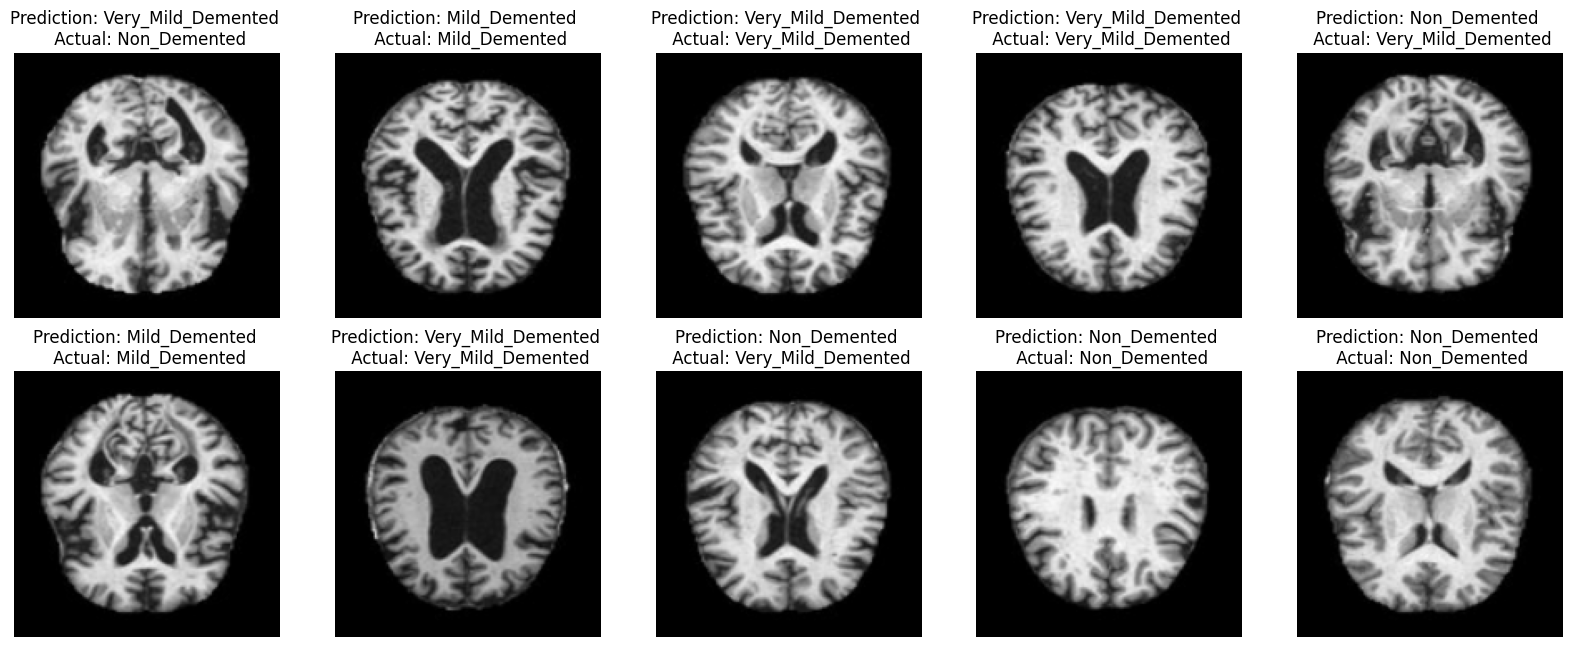

In [30]:
# plot the prediction vs actual label
plt.figure(figsize = (20,20))
for i in range(10):
  axs = plt.subplot(5,5,i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  current_prediction = class_names[class_predictions[i]]
  current_label = class_names[label_batch[i]]
  plt.title(f"Prediction: {current_prediction} \n Actual: {current_label}")
  plt.axis('off')

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# Initialize empty arrays to store predictions and labels
all_predictions = []
all_labels = []

# Iterate through all batches in the test data
for image_batch, label_batch in test_data.as_numpy_iterator():
    predictions = model.predict_on_batch(image_batch)
    class_predictions = np.argmax(predictions, axis=1)
    
    # Append current batch predictions and labels to the arrays
    all_predictions.extend(class_predictions)
    all_labels.extend(label_batch)

# Convert the lists to numpy arrays for easy calculation
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(all_labels, all_predictions, target_names=class_names)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[ 84   0   2   3]
 [  2   5   2   0]
 [  9   0 301  10]
 [ 20   0  34 168]]
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.73      0.94      0.82        89
 Moderate_Demented       1.00      0.56      0.71         9
      Non_Demented       0.89      0.94      0.91       320
Very_Mild_Demented       0.93      0.76      0.83       222

          accuracy                           0.87       640
         macro avg       0.89      0.80      0.82       640
      weighted avg       0.88      0.87      0.87       640



In [32]:
pip install mlxtend



[notice] A new release of pip is available: 23.3 -> 23.3.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


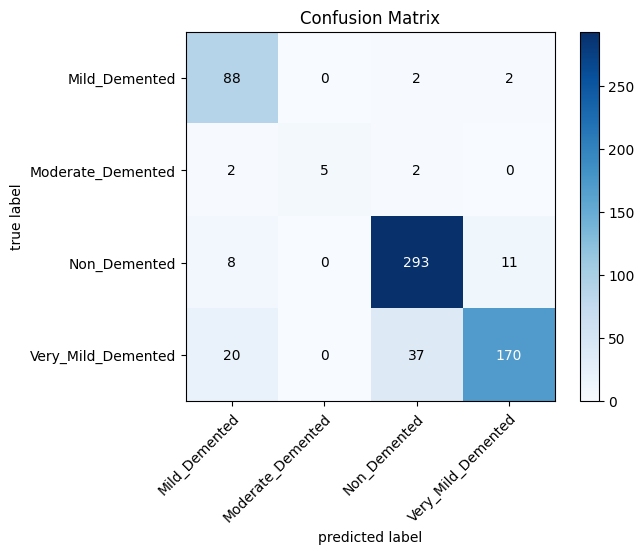

Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.75      0.96      0.84        92
 Moderate_Demented       1.00      0.56      0.71         9
      Non_Demented       0.88      0.94      0.91       312
Very_Mild_Demented       0.93      0.75      0.83       227

          accuracy                           0.87       640
         macro avg       0.89      0.80      0.82       640
      weighted avg       0.88      0.87      0.87       640



In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import pandas as pd

# Initialize empty arrays to store predictions and labels
all_predictions = []
all_labels = []

# Iterate through all batches in the test data
for image_batch, label_batch in test_data.as_numpy_iterator():
    predictions = model.predict_on_batch(image_batch)
    class_predictions = np.argmax(predictions, axis=1)
    
    # Append current batch predictions and labels to the arrays
    all_predictions.extend(class_predictions)
    all_labels.extend(label_batch)

# Convert the lists to numpy arrays for easy calculation
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Convert confusion matrix to a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plot Confusion Matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, show_normed=False, colorbar=True, class_names=class_names)
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_predictions, target_names=class_names)
print("Classification Report:")
print(class_report)


512/512 [==============================] - 778s 2s/step - loss: 0.1057 - accuracy: 0.9631 - val_loss: 0.1940 - val_accuracy: 0.9250


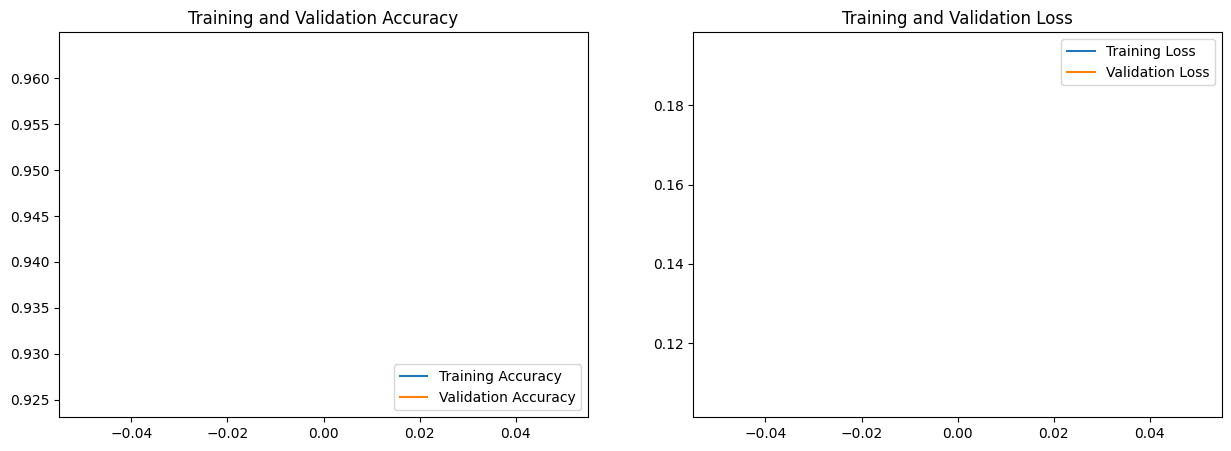

In [35]:
# start train the model
initial_epochs = 1
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data,
                    callbacks=[tensorboard_callback, es_callback])

# Plot accuracy and loss at each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(15, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

512/512 [==============================] - 876s 2s/step - loss: 0.0776 - accuracy: 0.9734 - val_loss: 0.1383 - val_accuracy: 0.9422


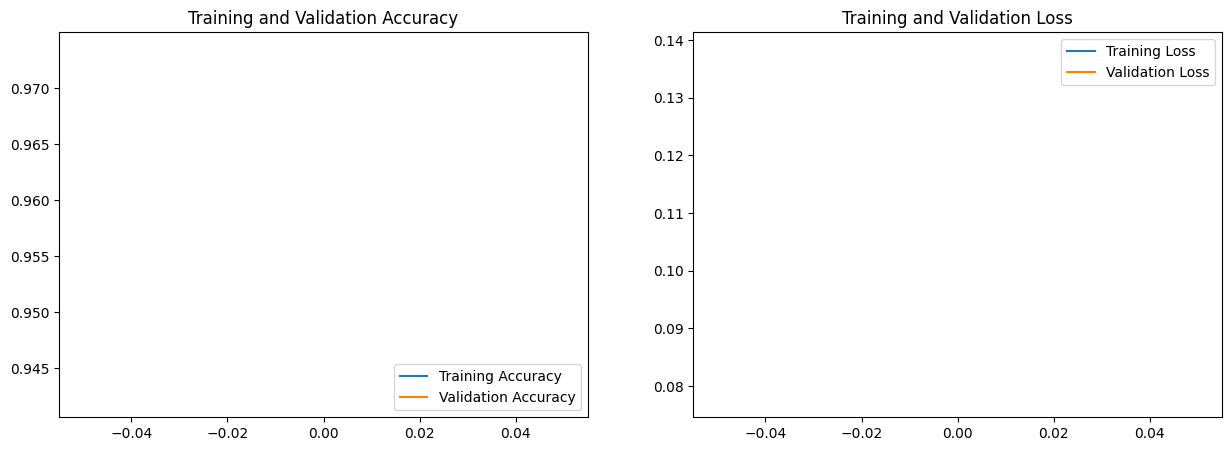

In [36]:
# start train the model
initial_epochs = 1
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data,
                    callbacks=[tensorboard_callback, es_callback])

# Plot accuracy and loss at each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(15, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Epoch 1/5
512/512 [==============================] - 844s 2s/step - loss: 0.0649 - accuracy: 0.9799 - val_loss: 0.3596 - val_accuracy: 0.8859
Epoch 2/5
512/512 [==============================] - 909s 2s/step - loss: 0.0460 - accuracy: 0.9855 - val_loss: 0.0982 - val_accuracy: 0.9625
Epoch 3/5
512/512 [==============================] - 921s 2s/step - loss: 0.0423 - accuracy: 0.9873 - val_loss: 0.0590 - val_accuracy: 0.9797
Epoch 4/5
512/512 [==============================] - 889s 2s/step - loss: 0.0442 - accuracy: 0.9887 - val_loss: 0.0458 - val_accuracy: 0.9797
Epoch 5/5
512/512 [==============================] - 986s 2s/step - loss: 0.0336 - accuracy: 0.9904 - val_loss: 0.0596 - val_accuracy: 0.9750


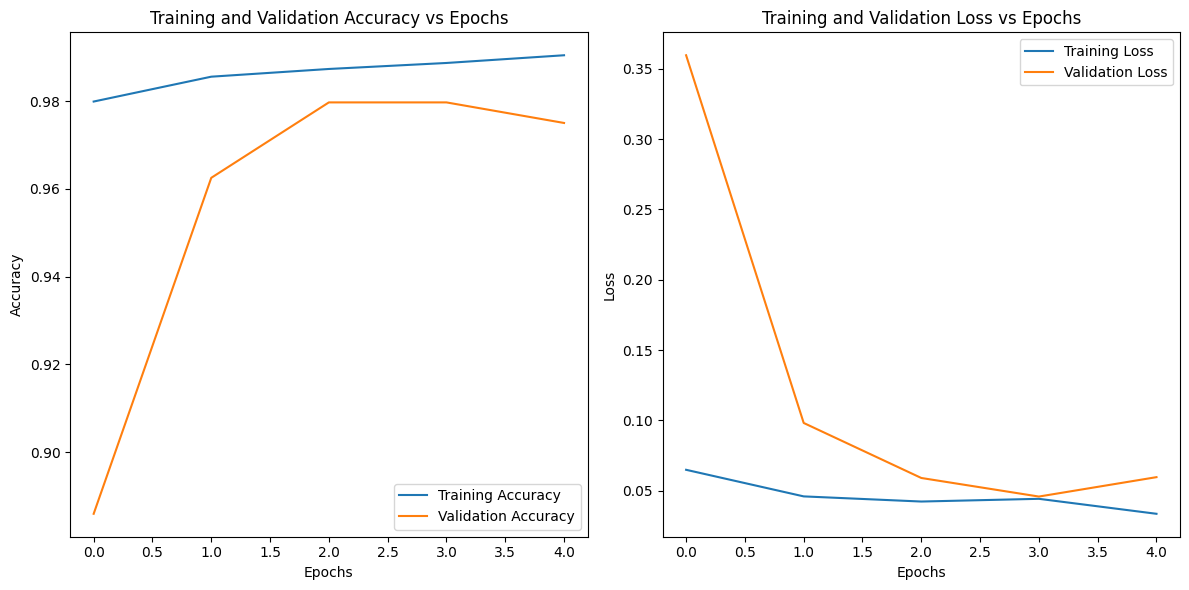

In [37]:
# ... (your existing code)

# Define callbacks for tracking training history
history_callback = model.fit(
    train_data,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_data,
    callbacks=[tensorboard_callback, es_callback],
)

# Get the training history
history_dict = history_callback.history

# Plot training/validation accuracy vs epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training/validation loss vs epochs
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
